In [1]:
%matplotlib inline


# Probability calibration of classifiers


When performing classification you often want to predict not only
the class label, but also the associated probability. This probability
gives you some kind of confidence on the prediction. However, not all
classifiers provide well-calibrated probabilities, some being over-confident
while others being under-confident. Thus, a separate calibration of predicted
probabilities is often desirable as a postprocessing. This example illustrates
two different methods for this calibration and evaluates the quality of the
returned probabilities using Brier's score
(see https://en.wikipedia.org/wiki/Brier_score).

Compared are the estimated probability using a Gaussian naive Bayes classifier
without calibration, with a sigmoid calibration, and with a non-parametric
isotonic calibration. One can observe that only the non-parametric model is able
to provide a probability calibration that returns probabilities close to the
expected 0.5 for most of the samples belonging to the middle cluster with
heterogeneous labels. This results in a significantly improved Brier score.


In [2]:
print(__doc__)

# Author: Mathieu Blondel <mathieu@mblondel.org>
#         Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Balazs Kegl <balazs.kegl@gmail.com>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split


n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Automatically created module for IPython interactive environment
Brier scores: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


Plot the data and the predicted probabilities


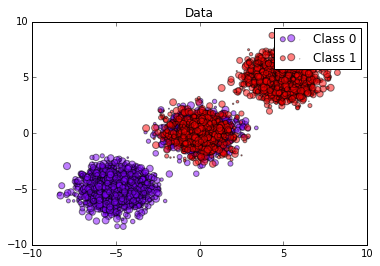

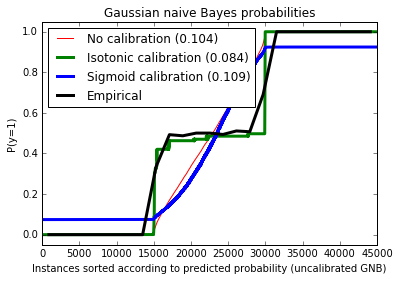

In [3]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color, alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()